### Load packages

In [70]:
import numpy as np
import pandas as pd
import time
from sklearn import model_selection, preprocessing, metrics, ensemble
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd
from datetime import datetime
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor



### Read files

In [2]:
## Read the input files ##
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test_QoiMO9B.csv")
fci_df = pd.read_csv("fulfilment_center_info.csv")
mi_df = pd.read_csv("meal_info.csv")

train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [3]:
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [4]:
fci_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [5]:
mi_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


### Check for categorical variable shift between train and test ID


In [6]:
train_df["id"].unique()

array([1379560, 1466964, 1346989, ..., 1110849, 1147725, 1361984],
      dtype=int64)

In [7]:
test_df["id"].unique()

array([1028232, 1127204, 1212707, ..., 1158107, 1444235, 1291286],
      dtype=int64)

In [8]:
train_df["center_id"].unique()

array([ 55,  24,  11,  83,  32,  13, 109,  52,  93, 186, 146,  57, 149,
        89, 124, 152,  97,  74, 108,  99,  66,  94,  91,  20,  34, 137,
        92, 126,  36, 162,  75, 177,  27, 157, 106,  64, 129,  14,  17,
       153, 139, 161,  81,  26,  73,  50, 104,  42, 113, 145,  53,  72,
        67, 174,  29,  77,  41,  30,  76,  59,  88, 143,  58,  10, 101,
        80,  43,  65,  39, 102, 110, 132,  23,  86,  68,  51,  61],
      dtype=int64)

In [9]:
test_df["center_id"].unique()

array([ 55,  24,  11,  83,  32,  13, 109,  52,  93, 186, 146,  57, 149,
        89, 124, 152,  97,  74, 108,  99,  66,  94,  91,  20,  34, 137,
        92, 126,  36, 162,  75, 177,  27, 157, 106,  64, 129,  14,  17,
       153, 139, 161,  81,  26,  73,  50, 104,  42, 113, 145,  53,  72,
        67, 174,  29,  77,  41,  30,  76,  59,  88, 143,  58,  10, 101,
        80,  43,  65,  39, 102, 110, 132,  23,  86,  68,  51,  61],
      dtype=int64)

In [10]:
train_df["meal_id"].unique()

array([1885, 1993, 2539, 2139, 2631, 1248, 1778, 1062, 2707, 1207, 1230,
       2322, 2290, 1727, 1109, 2640, 2306, 2126, 2826, 1754, 1971, 1902,
       1311, 1803, 1558, 2581, 1962, 1445, 2444, 2867, 1525, 2704, 2304,
       2577, 1878, 1216, 1247, 1770, 1198, 1438, 2494, 1847, 2760, 2492,
       1543, 2664, 2569, 2490, 1571, 2956, 2104], dtype=int64)

In [11]:
test_df["meal_id"].unique()

array([1885, 1993, 2539, 2631, 1248, 1778, 1062, 2707, 1207, 1230, 2322,
       2290, 1727, 1109, 2577, 2640, 2826, 1754, 1971, 1198, 1311, 1803,
       1558, 2581, 1962, 2444, 2867, 1525, 2704, 2492, 1543, 2304, 2664,
       2569, 2490, 2139, 1571, 2956, 1878, 2306, 1216, 2126, 1902, 1770,
       1438, 2494, 1847, 1445, 2760, 1247, 2104], dtype=int64)

## id

In [12]:
train_ids = set(train_df['id'].unique())
test_ids = set(test_df['id'].unique())

print("Train ids count : ", len(train_ids))
print("Test ids count : ",len(test_ids))
print("Common ids count : ", len(train_ids.intersection(test_ids)))

Train ids count :  456548
Test ids count :  32573
Common ids count :  0


## center_id

In [13]:
train_center_ids = set(train_df['center_id'].unique())
test_center_ids = set(test_df['center_id'].unique())

print("Train center ids count : ", len(train_center_ids))
print("Test center ids count : ",len(test_center_ids))
print("Common center ids count : ", len(train_center_ids.intersection(test_center_ids)))

Train center ids count :  77
Test center ids count :  77
Common center ids count :  77


In [14]:
train_center_ids = set(train_df['center_id'].unique())
fci_center_ids = set(fci_df['center_id'].unique())

print("Train center ids count : ", len(train_center_ids))
print("fci center ids count : ",len(fci_center_ids))
print("Common center ids count : ", len(train_center_ids.intersection(fci_center_ids)))

Train center ids count :  77
fci center ids count :  77
Common center ids count :  77


In [15]:
test_center_ids = set(test_df['center_id'].unique())
fci_center_ids = set(fci_df['center_id'].unique())

print("Test center ids count : ", len(test_center_ids))
print("fci center ids count : ",len(fci_center_ids))
print("Common center ids count : ", len(test_center_ids.intersection(fci_center_ids)))

Test center ids count :  77
fci center ids count :  77
Common center ids count :  77


## meal_id

In [16]:
train_meal_ids = set(train_df['meal_id'].unique())
test_meal_ids = set(test_df['meal_id'].unique())

print("Train meal ids count : ", len(train_meal_ids))
print("Test meal ids count : ",len(test_meal_ids))
print("Common meal ids count : ", len(train_meal_ids.intersection(test_meal_ids)))

Train meal ids count :  51
Test meal ids count :  51
Common meal ids count :  51


In [17]:
train_meal_ids = set(train_df['meal_id'].unique())
mi_meal_ids = set(mi_df['meal_id'].unique())

print("Train  ids count : ", len(train_meal_ids))
print("meal  ids count : ",len(mi_meal_ids))
print("Common center ids count : ", len(train_meal_ids.intersection(mi_meal_ids)))

Train  ids count :  51
meal  ids count :  51
Common center ids count :  51


In [18]:
test_meal_ids = set(test_df['meal_id'].unique())
mi_meal_ids = set(mi_df['meal_id'].unique())

print("Test  ids count : ", len(test_meal_ids))
print("meal  ids count : ",len(mi_meal_ids))
print("Common center ids count : ", len(test_meal_ids.intersection(mi_meal_ids)))

Test  ids count :  51
meal  ids count :  51
Common center ids count :  51


In [19]:
print("Train and test shape : ", train_df.shape, test_df.shape)

Train and test shape :  (456548, 9) (32573, 8)


In [20]:
### Get the mapping information
train_df_1 = pd.merge(train_df, fci_df, on = 'center_id', how = 'left')
test_df_1 = pd.merge(test_df, fci_df, on = 'center_id', how = 'left')

In [21]:
train_df_1.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0


In [22]:
### Get the mapping information
train_df_2 = pd.merge(train_df_1, mi_df, on = 'meal_id', how = 'left')
test_df_2 = pd.merge(test_df_1, mi_df, on = 'meal_id', how = 'left')

In [23]:
train_df_2.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [24]:
### Check the missing values
train_df_2.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64

In [25]:
### Check the missing values
test_df_2.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64

In [26]:
test_df_2.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai
1,1127204,146,55,1993,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai
2,1212707,146,55,2539,157.14,159.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai
3,1082698,146,55,2631,162.02,162.02,0,0,647,56,TYPE_C,2.0,Beverages,Indian
4,1400926,146,55,1248,163.93,163.93,0,0,647,56,TYPE_C,2.0,Beverages,Indian


In [27]:
train_df = train_df_2.copy()
test_df = test_df_2.copy()

In [28]:
train_df.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
city_code                  int64
region_code                int64
center_type               object
op_area                  float64
category                  object
cuisine                   object
dtype: object

In [29]:
np.unique(train_df['cuisine'])

array(['Continental', 'Indian', 'Italian', 'Thai'], dtype=object)

In [30]:
np.unique(train_df['category'])

array(['Beverages', 'Biryani', 'Desert', 'Extras', 'Fish', 'Other Snacks',
       'Pasta', 'Pizza', 'Rice Bowl', 'Salad', 'Sandwich', 'Seafood',
       'Soup', 'Starters'], dtype=object)

In [31]:
np.unique(train_df['center_type'])

array(['TYPE_A', 'TYPE_B', 'TYPE_C'], dtype=object)

In [32]:
train_df['center_type'].value_counts()

TYPE_A    262881
TYPE_C     99593
TYPE_B     94074
Name: center_type, dtype: int64

In [33]:
np.unique(train_df['region_code'])

array([23, 34, 35, 56, 71, 77, 85, 93], dtype=int64)

In [34]:
np.unique(train_df['city_code'])

array([456, 461, 473, 478, 485, 515, 517, 522, 526, 541, 553, 556, 561,
       562, 576, 577, 579, 590, 593, 596, 599, 602, 604, 609, 614, 615,
       620, 628, 632, 638, 647, 648, 649, 651, 654, 658, 659, 675, 676,
       679, 680, 683, 685, 693, 695, 698, 699, 700, 702, 703, 713],
      dtype=int64)

## Exploratory Data Analysis

In [35]:
train_df.groupby('center_type')['num_orders'].describe()

,count,mean,std,min,25%,50%,75%,max
center_type,,,,,,,,
TYPE_A,262881.0,262.394456,401.513549,13.0,54.0,136.0,324.0,24299.0
TYPE_B,94074.0,318.856145,436.773777,13.0,69.0,176.0,392.0,13580.0
TYPE_C,99593.0,206.670097,326.716100,13.0,40.0,107.0,258.0,10124.0


In [36]:
train_df.groupby('region_code')['num_orders'].describe()

,count,mean,std,min,25%,50%,75%,max
region_code,,,,,,,,
23,6434.0,250.218527,355.900672,13.0,42.0,109.0,325.0,5143.0
34,116713.0,206.075870,280.469659,13.0,53.0,123.0,270.0,12327.0
35,5264.0,131.277356,147.165513,13.0,40.0,94.0,188.0,2349.0
56,191228.0,316.481849,477.083280,13.0,55.0,161.0,404.0,24299.0
71,6293.0,334.225648,563.061248,13.0,53.0,123.0,432.0,12137.0
77,94612.0,216.987835,301.863129,13.0,53.0,134.0,284.0,10124.0
85,30283.0,286.807318,395.241494,13.0,55.0,149.0,366.0,8612.0
93,5721.0,238.820136,479.509199,13.0,53.0,122.0,258.0,9303.0


In [37]:
train_df.groupby('cuisine')['num_orders'].describe()

,count,mean,std,min,25%,50%,75%,max
cuisine,,,,,,,,
Continental,102795.0,164.545348,183.100493,13.0,54.0,108.0,203.0,2620.0
Indian,112612.0,229.039037,483.938740,13.0,28.0,68.0,242.0,24299.0
Italian,122925.0,359.347830,448.694495,13.0,107.0,256.0,446.0,13150.0
Thai,118216.0,276.423411,352.759286,13.0,69.0,161.0,338.0,9303.0


In [38]:
train_df.groupby('category')['num_orders'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Beverages,127890.0,316.526116,375.280914,13.0,81.0,189.0,404.0,9303.0
Biryani,20614.0,30.651402,22.092493,13.0,14.0,26.0,41.0,242.0
Desert,29294.0,66.250905,60.239531,13.0,27.0,53.0,82.0,1054.0
Extras,13562.0,293.834169,232.045222,13.0,123.0,217.0,393.0,1620.0
Fish,10187.0,85.595268,80.303895,13.0,28.0,67.0,109.0,879.0
Other Snacks,29379.0,162.234691,168.654453,13.0,54.0,109.0,215.0,3861.0
Pasta,27694.0,59.137142,54.081742,13.0,26.0,42.0,80.0,824.0
Pizza,33138.0,222.817309,227.976970,13.0,82.0,149.0,271.0,2620.0
Rice Bowl,33408.0,624.822288,745.306184,13.0,258.0,433.0,717.0,24299.0


In [39]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [40]:
train_df['check_base'] = train_df['checkout_price']/train_df['base_price']
test_df['check_base'] = test_df['checkout_price']/test_df['base_price']

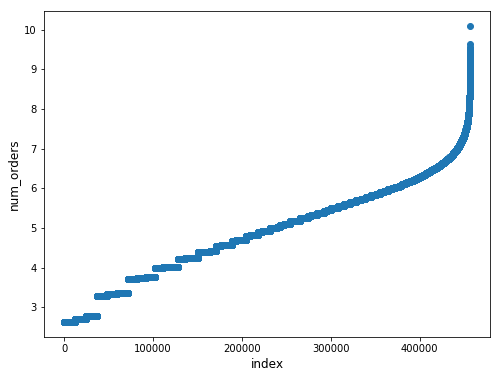

In [41]:
train_df["num_orders"] = train_df["num_orders"].astype('float')
gdf = train_df.groupby("id")["num_orders"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["num_orders"].values)))

plt.xlabel('index', fontsize=12)
plt.ylabel('num_orders', fontsize=12)
plt.show()

In [42]:
#Create log variable
train_df['log_num_orders'] = np.log1p(train_df["num_orders"])

(array([4.54511e+05, 1.75500e+03, 2.08000e+02, 4.80000e+01, 1.80000e+01,
        6.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.30000e+01, 2.44160e+03, 4.87020e+03, 7.29880e+03, 9.72740e+03,
        1.21560e+04, 1.45846e+04, 1.70132e+04, 1.94418e+04, 2.18704e+04,
        2.42990e+04]),
 <a list of 10 Patch objects>)

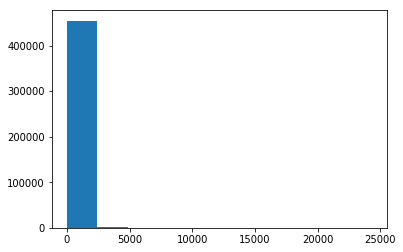

In [43]:
plt.hist(train_df['num_orders'])

(array([7.14280e+04, 5.67570e+04, 9.02830e+04, 1.03385e+05, 8.57870e+04,
        3.77230e+04, 9.47400e+03, 1.50300e+03, 1.99000e+02, 9.00000e+00]),
 array([ 2.63905733,  3.38497476,  4.13089219,  4.87680962,  5.62272705,
         6.36864448,  7.11456191,  7.86047934,  8.60639677,  9.3523142 ,
        10.09823163]),
 <a list of 10 Patch objects>)

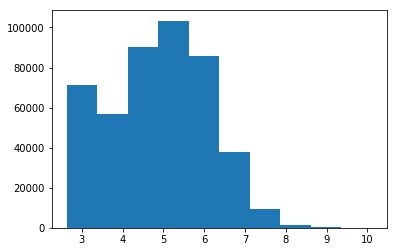

In [44]:
plt.hist(train_df['log_num_orders'] )

In [45]:
train_df.to_csv('train_df.csv')

In [46]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(dataset[column] , dataset['log_num_orders'])
    plt.ylabel('log_num_orders')
    plt.xlabel(column)

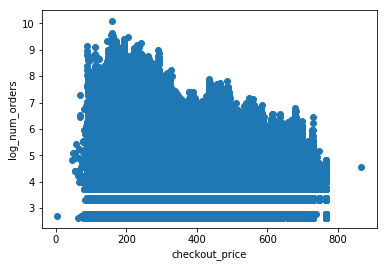

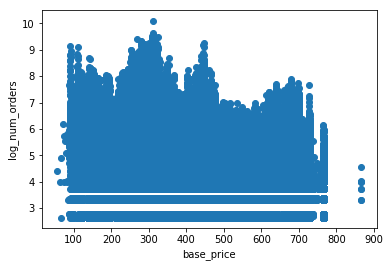

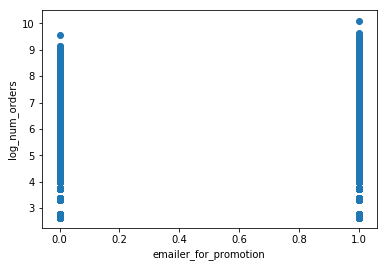

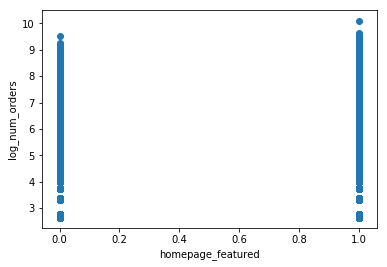

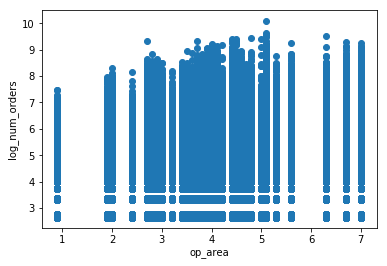

In [125]:
cols = ['checkout_price','base_price','emailer_for_promotion','homepage_featured', 'op_area']
for col in cols:
    scatter(train_df, col)

In [47]:
train_df.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders               float64
city_code                  int64
region_code                int64
center_type               object
op_area                  float64
category                  object
cuisine                   object
check_base               float64
log_num_orders           float64
dtype: object

In [48]:
cat_cols = ['center_type','category', 'cuisine','region_code','city_code']

In [49]:
## adding label ecnoders
for c in cat_cols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[c].values.astype('str')) + list(test_df[c].values.astype('str')))
    train_df[c] = lbl.transform(list(train_df[c].values.astype('str')))
    test_df[c] = lbl.transform(list(test_df[c].values.astype('str')))

In [50]:
train_df.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,check_base,log_num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,30,3,2,2.0,0,3,0.898483,5.181784
1,1466964,1,55,1993,136.83,135.83,0,0,270.0,30,3,2,2.0,0,3,1.007362,5.602119
2,1346989,1,55,2539,134.86,135.86,0,0,189.0,30,3,2,2.0,0,3,0.992639,5.247024
3,1338232,1,55,2139,339.50,437.53,0,0,54.0,30,3,2,2.0,0,1,0.775947,4.007333
4,1448490,1,55,2631,243.50,242.50,0,0,40.0,30,3,2,2.0,0,1,1.004124,3.713572


In [51]:
train_df["unique_id"] = train_df["week"].map(str) + train_df["center_id"].map(str)  +train_df['meal_id'].map(str) 

In [52]:
test_df["unique_id"] = test_df["week"].map(str) + test_df["center_id"].map(str)  +test_df['meal_id'].map(str) 

### Baseline Model

In [53]:
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error

C:\Users\HP\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [54]:
def cust_RMSLE(y_true, y_pred):
    return mean_squared_error(np.log1p(y_true), np.log1p(y_pred))

In [55]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None): 
    params = {}
    params["objective"] = "regression"
    params['metric'] = "rmse"
    params["max_depth"] = 10
    params["min_data_in_leaf"] = 100
    params["learning_rate"] = 0.001
    params["bagging_fraction"] = 0.7
    params["feature_fraction"] = 0.7
    params["bagging_freq"] = 5
    params["bagging_seed"] = 0
    params["verbosity"] = -1
    num_rounds = 10000
#     0.001 - best

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=100, verbose_eval=50)
                         
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:        
        loss = metrics.mean_squared_error(test_y, pred_test_y)
        print(loss)
        return pred_test_y, model, loss, pred_test_y2
    else:
        return pred_test_y, model, loss, pred_test_y2

In [56]:

train_df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'check_base', 'log_num_orders', 'unique_id'],
      dtype='object')

In [57]:
train_df.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders               float64
city_code                  int64
region_code                int64
center_type                int64
op_area                  float64
category                   int64
cuisine                    int64
check_base               float64
log_num_orders           float64
unique_id                 object
dtype: object

In [58]:
num_cols = ["checkout_price","base_price", "emailer_for_promotion", "homepage_featured",  "op_area"]    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

In [59]:
# Split the train dataset into development and valid based on time 
split_week = 120

dev_df = train_df[train_df['week']<=split_week]
val_df = train_df[train_df['week']>split_week]
dev_y = (dev_df["log_num_orders"].values)
val_y = (val_df["log_num_orders"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 

In [60]:
dev_X.head()

,center_type,category,cuisine,region_code,city_code,checkout_price,base_price,emailer_for_promotion,homepage_featured,op_area
0,2,0,3,3,30,136.83,152.29,0.0,0.0,2.0
1,2,0,3,3,30,136.83,135.83,0.0,0.0,2.0
2,2,0,3,3,30,134.86,135.86,0.0,0.0,2.0
3,2,0,1,3,30,339.50,437.53,0.0,0.0,2.0
4,2,0,1,3,30,243.50,242.50,0.0,0.0,2.0


In [61]:
test_X.head()

,center_type,category,cuisine,region_code,city_code,checkout_price,base_price,emailer_for_promotion,homepage_featured,op_area
0,2,0,3,3,30,158.11,159.11,0.0,0.0,2.0
1,2,0,3,3,30,160.11,159.11,0.0,0.0,2.0
2,2,0,3,3,30,157.14,159.14,0.0,0.0,2.0
3,2,0,1,3,30,162.02,162.02,0.0,0.0,2.0
4,2,0,1,3,30,163.93,163.93,0.0,0.0,2.0


In [62]:
# Training the model #
# pred_test, model, pred_val = runLGB(dev_X, dev_y, val_X, val_y, test_X)
pred_val, model, loss, pred_test = runLGB(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 1.14738
[100]	valid_0's rmse: 1.11963
[150]	valid_0's rmse: 1.09155
[200]	valid_0's rmse: 1.06661
[250]	valid_0's rmse: 1.04297
[300]	valid_0's rmse: 1.02201
[350]	valid_0's rmse: 1.00194
[400]	valid_0's rmse: 0.983641
[450]	valid_0's rmse: 0.964436
[500]	valid_0's rmse: 0.946071
[550]	valid_0's rmse: 0.92923
[600]	valid_0's rmse: 0.914889
[650]	valid_0's rmse: 0.899963
[700]	valid_0's rmse: 0.886382
[750]	valid_0's rmse: 0.873438
[800]	valid_0's rmse: 0.861519
[850]	valid_0's rmse: 0.850237
[900]	valid_0's rmse: 0.839805
[950]	valid_0's rmse: 0.830068
[1000]	valid_0's rmse: 0.820559
[1050]	valid_0's rmse: 0.812138
[1100]	valid_0's rmse: 0.804191
[1150]	valid_0's rmse: 0.796321
[1200]	valid_0's rmse: 0.789154
[1250]	valid_0's rmse: 0.782313
[1300]	valid_0's rmse: 0.776003
[1350]	valid_0's rmse: 0.770034
[1400]	valid_0's rmse: 0.764161
[1450]	valid_0's rmse: 0.758687
[1500]	valid_0's rmse: 0.753577
[1550

In [63]:
pred_val
# 53337.581497873354
# 0.36583090465234
# 0.3532734496063996
# 0.3534812045775591
# 0.34312657782159933
# 0.3442498109181905

array([5.17169515, 5.17318517, 5.17592635, ..., 5.84563778, 5.76499669,
       5.55550463])

In [64]:
pred_val_1 = np.exp(pred_val)

In [65]:
np.unique(pred_val_1 < 0, return_counts=True)

(array([False]), array([82150], dtype=int64))

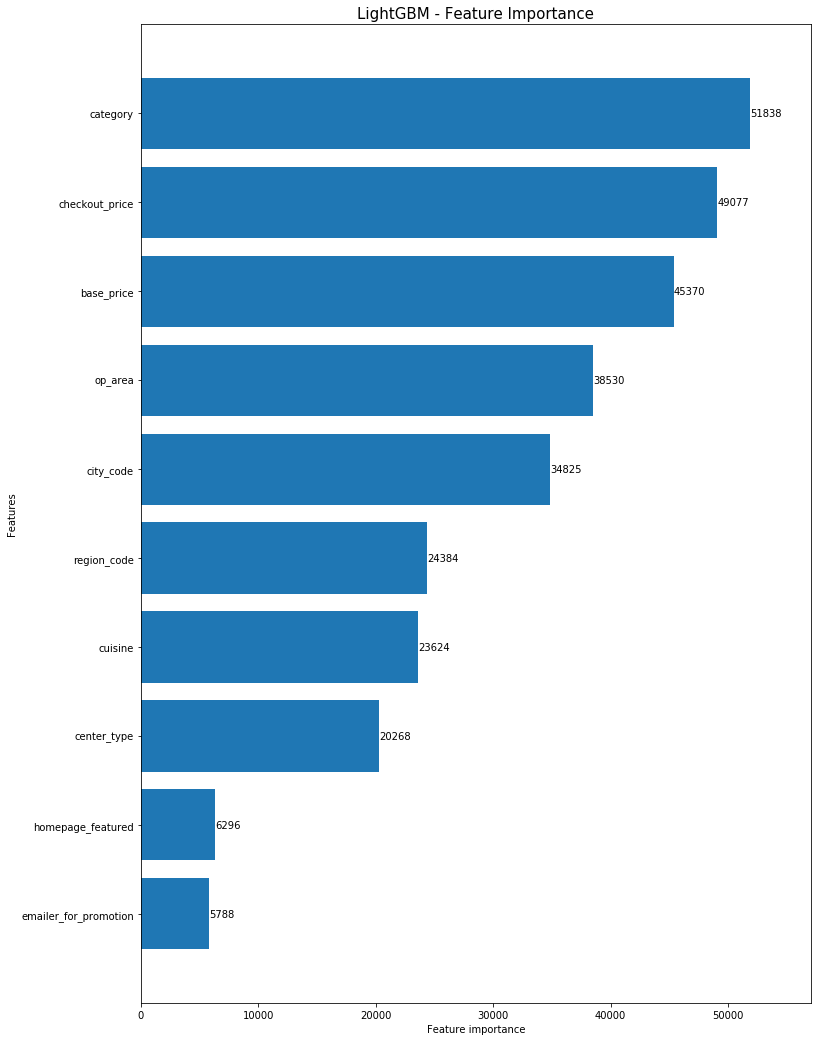

In [66]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [265]:
# pred_test[pred_test<0] = 0
# Read the submission file
submission=pd.read_csv("sample_submission.csv")
# # # ActionPoint is the variable with the predictions
submission['num_orders']= pd.DataFrame(np.exp(pred_test))

# # Converting the submission file to csv format
submission.to_csv('lgb_7_lr_00001_new.csv', index=False)

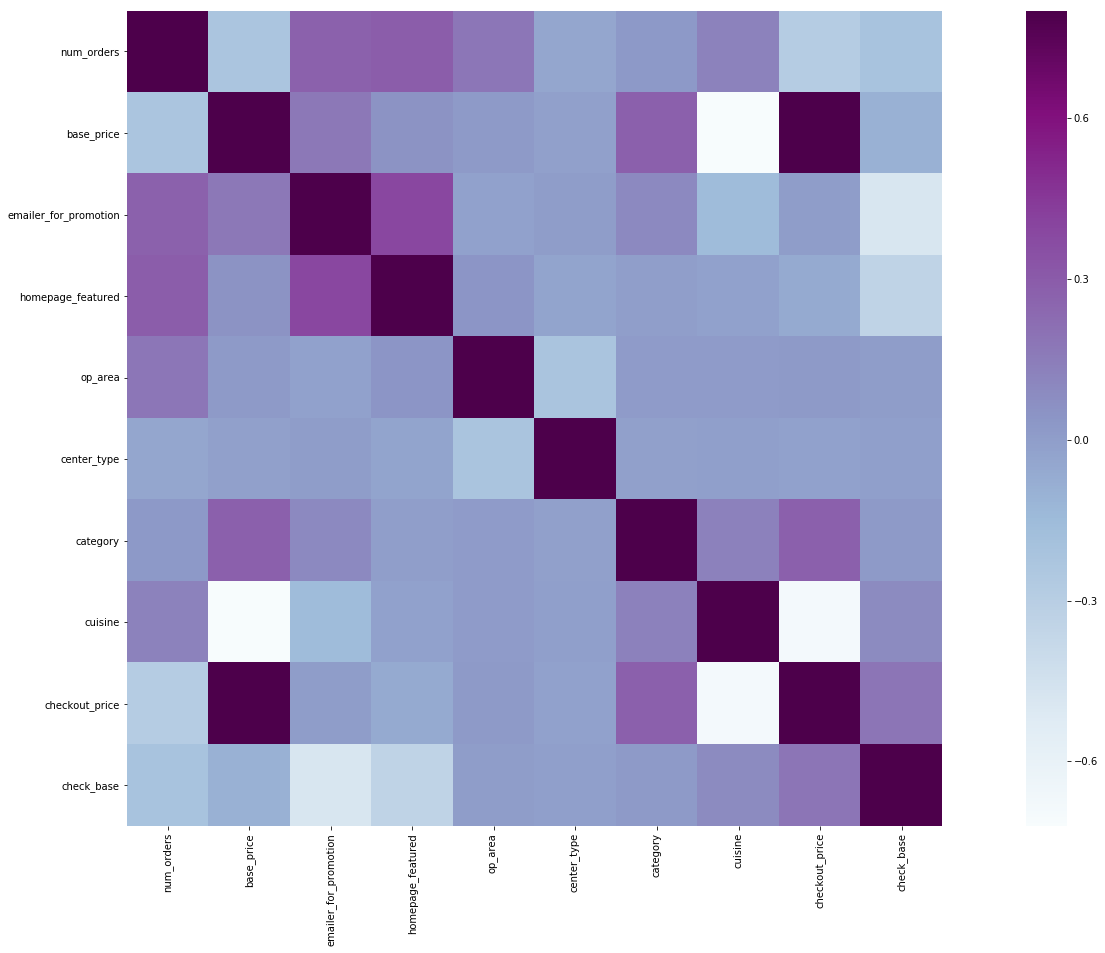

In [734]:
# Correlation between numerical variables
num_train_cols_data = (train_df[['num_orders', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'op_area',
                                'center_type', 'category', 'cuisine', 'checkout_price','check_base'
                                ]])
matrix = num_train_cols_data.corr()
f, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu");

In [71]:
train_df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'check_base', 'log_num_orders', 'unique_id'],
      dtype='object')

In [72]:
## Drop unnecesary columns
train_df = train_df.drop(['id', 'center_id', 'meal_id',  'base_price', 
           'unique_id'],axis =1 )
test_df = test_df.drop(['id', 'center_id', 'meal_id',  'base_price', 
            'unique_id'],axis =1 )

### Feature engineering

In [73]:
train_df['area_mult_checkprice'] = train_df['op_area']*train_df['checkout_price']
test_df['area_mult_checkprice'] = test_df['op_area']*test_df['checkout_price']

train_df['area_square'] = train_df['op_area'] *train_df['op_area']
test_df['area_square'] = test_df['op_area']*test_df['op_area']

train_df['checkprice_per_area'] = train_df['checkout_price']/train_df['op_area']
test_df['checkprice_per_area'] = test_df['checkout_price']/test_df['op_area']



In [144]:
# # Prints R2 and RMSE scores
# def get_score(prediction, lables):    
#     print('R2: {}'.format(r2_score(prediction, lables)))
#     print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))
#     print('RMSLE: {}'.format(np.sqrt(mean_squared_log_error(prediction, lables))))

In [74]:
train_df.head(5)

,week,checkout_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,check_base,log_num_orders,area_mult_checkprice,area_square,checkprice_per_area
0,1,136.83,0.0,0.0,177.0,30,3,2,2.0,0,3,0.898483,5.181784,273.66,4.0,68.415
1,1,136.83,0.0,0.0,270.0,30,3,2,2.0,0,3,1.007362,5.602119,273.66,4.0,68.415
2,1,134.86,0.0,0.0,189.0,30,3,2,2.0,0,3,0.992639,5.247024,269.72,4.0,67.430
3,1,339.50,0.0,0.0,54.0,30,3,2,2.0,0,1,0.775947,4.007333,679.00,4.0,169.750
4,1,243.50,0.0,0.0,40.0,30,3,2,2.0,0,1,1.004124,3.713572,487.00,4.0,121.750


In [75]:
#Drop the base price
from pandas import concat
 
dataframe = concat([train_df.shift(1), train_df], axis=1)
dataframe_test =  concat([test_df.shift(1), test_df], axis=1)

In [76]:
dataframe.shape

(456548, 32)

In [77]:
dataframe.columns

Index(['week', 'checkout_price', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'city_code', 'region_code', 'center_type', 'op_area',
       'category', 'cuisine', 'check_base', 'log_num_orders',
       'area_mult_checkprice', 'area_square', 'checkprice_per_area', 'week',
       'checkout_price', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'city_code', 'region_code', 'center_type', 'op_area',
       'category', 'cuisine', 'check_base', 'log_num_orders',
       'area_mult_checkprice', 'area_square', 'checkprice_per_area'],
      dtype='object')

In [78]:
dataframe.shape

(456548, 32)

In [79]:
dataframe_test.columns

Index(['week', 'checkout_price', 'emailer_for_promotion', 'homepage_featured',
       'city_code', 'region_code', 'center_type', 'op_area', 'category',
       'cuisine', 'check_base', 'area_mult_checkprice', 'area_square',
       'checkprice_per_area', 'week', 'checkout_price',
       'emailer_for_promotion', 'homepage_featured', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'check_base', 'area_mult_checkprice', 'area_square',
       'checkprice_per_area'],
      dtype='object')

In [80]:
dataframe_test.shape

(32573, 28)

In [81]:
dataframe.columns = [
                     'week_lag_1','checkout_price_lag_1', 'emailer_for_promotion_lag_1', 'homepage_featured_lag_1',
                     'num_orders_lag_1', 'city_code_lag_1','region_code_lag_1', 'center_type_lag_1', 'op_area_lag_1', 
                     'category_lag_1','cuisine_lag_1','check_base_lag_1','log_num_orders_lag_1','area_mult_checkprice_lag_1', 
                    'area_square_lag_1', 'checkprice_per_area_lag_1',
                     
                     'week',
       'checkout_price', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'city_code', 'region_code', 'center_type', 'op_area',
       'category', 'cuisine', 'check_base', 'log_num_orders','area_mult_checkprice', 'area_square', 'checkprice_per_area']
dataframe.head(5)

dataframe_test.columns = [
                     'week_lag_1','checkout_price_lag_1', 'emailer_for_promotion_lag_1', 'homepage_featured_lag_1',
    'city_code_lag_1',
                          'region_code_lag_1',
                      'center_type_lag_1', 'op_area_lag_1', 'category_lag_1', 'cuisine_lag_1','check_base_lag_1',
    'area_mult_checkprice_lag_1', 
                    'area_square_lag_1', 'checkprice_per_area_lag_1',
                     'week', 'checkout_price',
       'emailer_for_promotion', 'homepage_featured', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'check_base','area_mult_checkprice', 'area_square', 'checkprice_per_area']
dataframe_test.head(5)

,week_lag_1,checkout_price_lag_1,emailer_for_promotion_lag_1,homepage_featured_lag_1,city_code_lag_1,region_code_lag_1,center_type_lag_1,op_area_lag_1,category_lag_1,cuisine_lag_1,...,city_code,region_code,center_type,op_area,category,cuisine,check_base,area_mult_checkprice,area_square,checkprice_per_area
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30,3,2,2.0,0,3,0.993715,316.22,4.0,79.055
1,146.0,158.11,0.0,0.0,30.0,3.0,2.0,2.0,0.0,3.0,...,30,3,2,2.0,0,3,1.006285,320.22,4.0,80.055
2,146.0,160.11,0.0,0.0,30.0,3.0,2.0,2.0,0.0,3.0,...,30,3,2,2.0,0,3,0.987432,314.28,4.0,78.570
3,146.0,157.14,0.0,0.0,30.0,3.0,2.0,2.0,0.0,3.0,...,30,3,2,2.0,0,1,1.000000,324.04,4.0,81.010
4,146.0,162.02,0.0,0.0,30.0,3.0,2.0,2.0,0.0,1.0,...,30,3,2,2.0,0,1,1.000000,327.86,4.0,81.965


In [82]:
dataframe.columns

Index(['week_lag_1', 'checkout_price_lag_1', 'emailer_for_promotion_lag_1',
       'homepage_featured_lag_1', 'num_orders_lag_1', 'city_code_lag_1',
       'region_code_lag_1', 'center_type_lag_1', 'op_area_lag_1',
       'category_lag_1', 'cuisine_lag_1', 'check_base_lag_1',
       'log_num_orders_lag_1', 'area_mult_checkprice_lag_1',
       'area_square_lag_1', 'checkprice_per_area_lag_1', 'week',
       'checkout_price', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'city_code', 'region_code', 'center_type', 'op_area',
       'category', 'cuisine', 'check_base', 'log_num_orders',
       'area_mult_checkprice', 'area_square', 'checkprice_per_area'],
      dtype='object')

In [83]:
cat_cols = [
    'center_type',
    'category', 'cuisine','city_code','region_code','category_lag_1', 'cuisine_lag_1','city_code_lag_1']

In [84]:
dataframe.dtypes

week_lag_1                     float64
checkout_price_lag_1           float64
emailer_for_promotion_lag_1    float64
homepage_featured_lag_1        float64
num_orders_lag_1               float64
city_code_lag_1                float64
region_code_lag_1              float64
center_type_lag_1              float64
op_area_lag_1                  float64
category_lag_1                 float64
cuisine_lag_1                  float64
check_base_lag_1               float64
log_num_orders_lag_1           float64
area_mult_checkprice_lag_1     float64
area_square_lag_1              float64
checkprice_per_area_lag_1      float64
week                             int64
checkout_price                 float64
emailer_for_promotion          float64
homepage_featured              float64
num_orders                     float64
city_code                        int64
region_code                      int64
center_type                      int64
op_area                        float64
category                 

In [85]:
num_cols = [
    "checkout_price", 
    "emailer_for_promotion", "homepage_featured",  "op_area" , 
            "checkout_price_lag_1" , "check_base_lag_1" ,  "op_area_lag_1" 

           ]    
for col in num_cols:
    dataframe[col] = dataframe[col].astype(float)
    dataframe[col] = dataframe[col].astype(float)

In [86]:
dataframe.head(5)

,week_lag_1,checkout_price_lag_1,emailer_for_promotion_lag_1,homepage_featured_lag_1,num_orders_lag_1,city_code_lag_1,region_code_lag_1,center_type_lag_1,op_area_lag_1,category_lag_1,...,region_code,center_type,op_area,category,cuisine,check_base,log_num_orders,area_mult_checkprice,area_square,checkprice_per_area
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,2,2.0,0,3,0.898483,5.181784,273.66,4.0,68.415
1,1.0,136.83,0.0,0.0,177.0,30.0,3.0,2.0,2.0,0.0,...,3,2,2.0,0,3,1.007362,5.602119,273.66,4.0,68.415
2,1.0,136.83,0.0,0.0,270.0,30.0,3.0,2.0,2.0,0.0,...,3,2,2.0,0,3,0.992639,5.247024,269.72,4.0,67.430
3,1.0,134.86,0.0,0.0,189.0,30.0,3.0,2.0,2.0,0.0,...,3,2,2.0,0,1,0.775947,4.007333,679.00,4.0,169.750
4,1.0,339.50,0.0,0.0,54.0,30.0,3.0,2.0,2.0,0.0,...,3,2,2.0,0,1,1.004124,3.713572,487.00,4.0,121.750


In [87]:
dataframe.head(4)

,week_lag_1,checkout_price_lag_1,emailer_for_promotion_lag_1,homepage_featured_lag_1,num_orders_lag_1,city_code_lag_1,region_code_lag_1,center_type_lag_1,op_area_lag_1,category_lag_1,...,region_code,center_type,op_area,category,cuisine,check_base,log_num_orders,area_mult_checkprice,area_square,checkprice_per_area
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,2,2.0,0,3,0.898483,5.181784,273.66,4.0,68.415
1,1.0,136.83,0.0,0.0,177.0,30.0,3.0,2.0,2.0,0.0,...,3,2,2.0,0,3,1.007362,5.602119,273.66,4.0,68.415
2,1.0,136.83,0.0,0.0,270.0,30.0,3.0,2.0,2.0,0.0,...,3,2,2.0,0,3,0.992639,5.247024,269.72,4.0,67.430
3,1.0,134.86,0.0,0.0,189.0,30.0,3.0,2.0,2.0,0.0,...,3,2,2.0,0,1,0.775947,4.007333,679.00,4.0,169.750


In [88]:
num_cols_test = [
    "checkout_price", 
    "emailer_for_promotion", "homepage_featured",  "op_area" , 
            "checkout_price_lag_1","check_base_lag_1" ,  "op_area_lag_1"
      

                ] 

# Split the train dataset into development and valid based on time 
split_week = 120
dataframe = dataframe.drop(dataframe.index[0])



dev_df = dataframe[dataframe['week']<=split_week]
val_df = dataframe[dataframe['week']>split_week]
dev_y = (dev_df["log_num_orders"].values)
val_y = (val_df["log_num_orders"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = dataframe_test[cat_cols + num_cols_test] 

In [89]:
dataframe.columns

Index(['week_lag_1', 'checkout_price_lag_1', 'emailer_for_promotion_lag_1',
       'homepage_featured_lag_1', 'num_orders_lag_1', 'city_code_lag_1',
       'region_code_lag_1', 'center_type_lag_1', 'op_area_lag_1',
       'category_lag_1', 'cuisine_lag_1', 'check_base_lag_1',
       'log_num_orders_lag_1', 'area_mult_checkprice_lag_1',
       'area_square_lag_1', 'checkprice_per_area_lag_1', 'week',
       'checkout_price', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'city_code', 'region_code', 'center_type', 'op_area',
       'category', 'cuisine', 'check_base', 'log_num_orders',
       'area_mult_checkprice', 'area_square', 'checkprice_per_area'],
      dtype='object')

In [90]:
test_X.columns

Index(['center_type', 'category', 'cuisine', 'city_code', 'region_code',
       'category_lag_1', 'cuisine_lag_1', 'city_code_lag_1', 'checkout_price',
       'emailer_for_promotion', 'homepage_featured', 'op_area',
       'checkout_price_lag_1', 'check_base_lag_1', 'op_area_lag_1'],
      dtype='object')

In [91]:
dev_X.columns

Index(['center_type', 'category', 'cuisine', 'city_code', 'region_code',
       'category_lag_1', 'cuisine_lag_1', 'city_code_lag_1', 'checkout_price',
       'emailer_for_promotion', 'homepage_featured', 'op_area',
       'checkout_price_lag_1', 'check_base_lag_1', 'op_area_lag_1'],
      dtype='object')

In [92]:
print(dev_X.shape, val_X.shape, test_X.shape)

(374397, 15) (82150, 15) (32573, 15)


In [93]:
X_train = dev_X
y_train = dev_y

X_test = val_X 
y_test = val_y

In [94]:
X_train.head(5)

,center_type,category,cuisine,city_code,region_code,category_lag_1,cuisine_lag_1,city_code_lag_1,checkout_price,emailer_for_promotion,homepage_featured,op_area,checkout_price_lag_1,check_base_lag_1,op_area_lag_1
1,2,0,3,30,3,0.0,3.0,30.0,136.83,0.0,0.0,2.0,136.83,0.898483,2.0
2,2,0,3,30,3,0.0,3.0,30.0,134.86,0.0,0.0,2.0,136.83,1.007362,2.0
3,2,0,1,30,3,0.0,3.0,30.0,339.50,0.0,0.0,2.0,134.86,0.992639,2.0
4,2,0,1,30,3,0.0,1.0,30.0,243.50,0.0,0.0,2.0,339.50,0.775947,2.0
5,2,0,1,30,3,0.0,1.0,30.0,251.23,0.0,0.0,2.0,243.50,1.004124,2.0


In [95]:
y_test

array([4.55387689, 4.80402104, 5.43807931, ..., 6.21860012, 6.59304453,
       5.0937502 ])

### RandomForest

In [96]:
clf = RandomForestRegressor( 
    n_estimators=100, max_features='log2', verbose=1 , 
    random_state = 1)
clf.fit(X_train, y_train)
pred_val = clf.predict(X_test)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   50.4s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished


In [97]:
pred_val

array([4.40369218, 5.12921783, 5.34956087, ..., 6.29120423, 6.09960071,
       5.94362354])

In [98]:
print(mean_squared_log_error(y_train, clf.predict(X_train)))
print(mean_squared_log_error(y_test, pred_val)) 

# 0.11941038815947692
# 0.37925975698955694

# 0.11088948720994792
# 0.3664355868337572



# 0.003598537499635042
# 0.012320848622923788

# 0.0025615923365947505
# 0.011827971247090906

0.0025761723214499884
0.011847454164287024


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.6s finished


Text(0.5,1,'Attribute Importance by RandomForest Application')

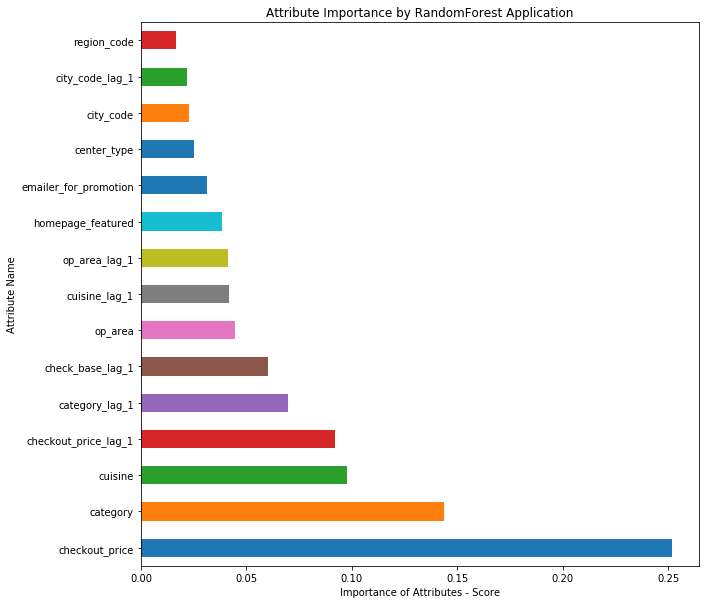

In [99]:
importances=pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances.plot(kind='barh', figsize=(10,10))
plt.xlabel('Importance of Attributes - Score')
plt.ylabel('Attribute Name')
plt.title("Attribute Importance by RandomForest Application")

In [100]:
# impute
test_X['checkout_price_lag_1']=test_X['checkout_price_lag_1'].fillna(test_X['checkout_price_lag_1'].mean())
test_X['check_base_lag_1']=test_X['check_base_lag_1'].fillna(test_X['check_base_lag_1'].mean())
test_X['category_lag_1']=test_X['category_lag_1'].fillna(test_X['category_lag_1'].mode()[0])
test_X['cuisine_lag_1']=test_X['cuisine_lag_1'].fillna(test_X['cuisine_lag_1'].mode()[0])
test_X['op_area_lag_1']=test_X['op_area_lag_1'].fillna(test_X['op_area_lag_1'].mean())
test_X['city_code_lag_1']=test_X['city_code_lag_1'].fillna(test_X['city_code_lag_1'].mean())

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

In [101]:
test_X.head(4)

,center_type,category,cuisine,city_code,region_code,category_lag_1,cuisine_lag_1,city_code_lag_1,checkout_price,emailer_for_promotion,homepage_featured,op_area,checkout_price_lag_1,check_base_lag_1,op_area_lag_1
0,2,0,3,30,3,0.0,2.0,22.634195,158.11,0.0,0.0,2.0,341.856448,0.956399,4.087713
1,2,0,3,30,3,0.0,3.0,30.000000,160.11,0.0,0.0,2.0,158.110000,0.993715,2.000000
2,2,0,3,30,3,0.0,3.0,30.000000,157.14,0.0,0.0,2.0,160.110000,1.006285,2.000000
3,2,0,1,30,3,0.0,3.0,30.000000,162.02,0.0,0.0,2.0,157.140000,0.987432,2.000000


In [102]:
pred_test = clf.predict(test_X)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


In [103]:
pred_test

array([5.3615663 , 5.25651742, 5.1209804 , ..., 5.77082417, 5.89509677,
       5.06873568])

In [259]:
# pred_test[pred_test<0] = 0
# Read the submission file
submission=pd.read_csv("sample_submission.csv")
# # # ActionPoint is the variable with the predictions
submission['num_orders']= pd.DataFrame(np.exp(pred_test))

# # Converting the submission file to csv format
submission.to_csv('rf_basic_feat_8_New.csv', index=False)

## Catboost

In [198]:
categorical_features_indices = [X_train.columns.get_loc(i) for i in cat_cols] 

In [199]:
categorical_features_indices

[0, 1, 2, 3, 4]

In [200]:
X_train.head(4)

,center_type,category,cuisine,city_code,region_code,checkout_price,emailer_for_promotion,homepage_featured,op_area,checkout_price_lag_1,check_base_lag_1
2,2,0,3,30,3,134.86,0.0,0.0,2.0,136.83,1.007362
3,2,0,1,30,3,339.50,0.0,0.0,2.0,134.86,0.992639
4,2,0,1,30,3,243.50,0.0,0.0,2.0,339.50,0.775947
5,2,0,1,30,3,251.23,0.0,0.0,2.0,243.50,1.004124


In [201]:
#importing library and building model
from catboost import CatBoostRegressor
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4.5580468	test: 4.5302034	best: 4.5302034 (0)	total: 192ms	remaining: 9.43s
1:	learn: 4.1264528	test: 4.1039509	best: 4.1039509 (1)	total: 382ms	remaining: 9.16s
2:	learn: 3.7403162	test: 3.7227676	best: 3.7227676 (2)	total: 515ms	remaining: 8.07s
3:	learn: 3.3953961	test: 3.3809819	best: 3.3809819 (3)	total: 629ms	remaining: 7.24s
4:	learn: 3.0876257	test: 3.0775130	best: 3.0775130 (4)	total: 726ms	remaining: 6.53s
5:	learn: 2.8136498	test: 2.8075285	best: 2.8075285 (5)	total: 847ms	remaining: 6.21s
6:	learn: 2.5701837	test: 2.5681071	best: 2.5681071 (6)	total: 937ms	remaining: 5.76s
7:	learn: 2.3542903	test: 2.3547609	best: 2.3547609 (7)	total: 1.03s	remaining: 5.42s
8:	learn: 2.1635456	test: 2.1672955	best: 2.1672955 (8)	total: 1.23s	remaining: 5.61s
9:	learn: 1.9945264	test: 2.0012516	best: 2.0012516 (9)	total: 1.37s	remaining: 5.49s
10:	learn: 1.8339268	test: 1.8406254	best: 1.8406254 (10)	total: 1.48s	remaining: 5.24s
11:	learn: 1.6854807	test: 1.6936676	best: 1.6936676

In [202]:
pred_val = model.predict(X_test)

In [204]:
print(mean_squared_log_error(y_train, model.predict(X_train)))
print(mean_squared_log_error(y_test, pred_val)) 

0.01654038527286718
0.01764374874116374


In [824]:
pred_test = model.predict(test_X)

In [827]:
pred_test.max()

2808.296982285986

* Random Forest Regressor gave the best solution. But I averagd all the solutions obtained by LightGBM and Randommforest regressor methods and 
submitted the solution. 

* My rank is 281 out of the ~4000 particpants who have registered for the Hackathon